### 552 Final Project -- Fake News Classifier

### Import libraries

In [196]:
import numpy as np
import pandas as pd
import nltk
from  tensorflow.keras.preprocessing import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection, feature_extraction, svm, pipeline, manifold, preprocessing, metrics
import matplotlib.pyplot as plt

### Prepare datasets

In [119]:
def preprocess(df):
    
    # Drop the incomplete rows
    flt = (df['text'].str.startswith('<|startoftext|>'))&(df['text'].str.endswith('<|endoftext|>'))&(df['text'].str.len()>100)
    filtered_df = df.loc[flt]
    
    # Remove the start/end marks
    df1 = list()
    for row in filtered_df['text']:
        row = row.replace('<|startoftext|>', '').replace('<|endoftext|>', '')
        df1.append(row)
    df1 = pd.DataFrame({'text':df1})
    
    #Remove duplicates
    df1 = df1.drop_duplicates()
    
    #Reset_index
    df1 = df1.reset_index(drop=True)
    
    return df1

#### Import the generated fake news

In [162]:
# Import he generated dataset
dt03 = pd.read_csv('gen_fake_news/gpt2_gentext_t03.txt', delimiter = "\t", names = ['text'])
dt05 = pd.read_csv('gen_fake_news/gpt2_gentext_t05.txt', delimiter = "\t", names = ['text'])
dt07 = pd.read_csv('gen_fake_news/gpt2_gentext_t07.txt', delimiter = "\t", names = ['text'])
dt10 = pd.read_csv('gen_fake_news/gpt2_gentext_t10.txt', delimiter = "\t", names = ['text'])

In [163]:
# Import the real news dataset
real = pd.read_csv('data/news_train_all.csv', names = ['text'], header=0)
usertest = pd.read_csv('user_study/user_test.csv')

In [164]:
# Preprocess the datasets
df03 = preprocess(dt03)
df05 = preprocess(dt05)
df07 = preprocess(dt07)
df10 = preprocess(dt10)

In [165]:
df03['label'] = 1
df05['label'] = 2
df07['label'] = 3
df10['label'] = 4

In [166]:
df03['class'] = 1
df05['class'] = 1
df07['class'] = 1
df10['class'] = 1
real['label'] = 0
real['class'] = 0 

In [167]:
temp =  pd.concat([real, df03, df05, df07, df10])

In [168]:
temp1 = temp.drop_duplicates(subset=(['text']), keep=False)

In [169]:
# text = usertest['text']

In [171]:
# drop = []
# for t in text:
#     for i in range(len(temp1)):
#         if temp1.iloc[i][0]==t:
#             print(temp1.iloc[i][0])
#             drop.append(i)

In [77]:
temp1.to_csv('all_fake_real_news.csv', index=False)

In [ ]:
# Randomly select 1000 from each group
df03 = temp[temp['label']==1].sample(1000)
df05 = temp[temp['label']==2].sample(1000)
df07 = temp[temp['label']==3].sample(1000)
df10 = temp[temp['label']==4].sample(1000)

In [ ]:
# Save the dataset to files
df03.to_csv('gen_fake_news/gpt2_gentext_t03.csv', index=False)
df05.to_csv('gen_fake_news/gpt2_gentext_t05.csv', index=False)
df07.to_csv('gen_fake_news/gpt2_gentext_t07.csv', index=False)
df10.to_csv('gen_fake_news/gpt2_gentext_t10.csv', index=False)

#### Data to Files

In [172]:
df03 = pd.read_csv('gen_fake_news/gpt2_gentext_t03.csv')
df05 = pd.read_csv('gen_fake_news/gpt2_gentext_t05.csv')
df07 = pd.read_csv('gen_fake_news/gpt2_gentext_t07.csv')
df10 = pd.read_csv('gen_fake_news/gpt2_gentext_t10.csv')

In [173]:
# Ramdonly select 3000 from the set
dfreal = real.sample(1000)
dfreal['class'] = 0

In [174]:
news03 = pd.concat([df03, dfreal])
news05 = pd.concat([df05, dfreal])
news07 = pd.concat([df07, dfreal])
news10 = pd.concat([df10, dfreal])
news = pd.concat([dfreal, df03, df05, df07, df10])

In [175]:
news03 = news03.reset_index(drop=True)
news05 = news05.reset_index(drop=True)
news07 = news07.reset_index(drop=True)
news10 = news10.reset_index(drop=True)
news = news.reset_index(drop=True)

In [176]:
news03.to_csv('gen_fake_news/gentext_train_03.csv', index=False)
news05.to_csv('gen_fake_news/gentext_train_05.csv', index=False)
news07.to_csv('gen_fake_news/gentext_train_07.csv', index=False)
news10.to_csv('gen_fake_news/gentext_train_10.csv', index=False)

In [177]:
news.to_csv('gen_fake_news/gentext_train.csv', index=False)

### Data Preprocessing

In [219]:
news03 = pd.read_csv('gen_fake_news/gentext_train_03.csv')
news05 = pd.read_csv('gen_fake_news/gentext_train_05.csv')
news07 = pd.read_csv('gen_fake_news/gentext_train_07.csv')
news10 = pd.read_csv('gen_fake_news/gentext_train_10.csv')

In [220]:
news03

,text,label,class
0,Officials of some of the world’s largest oil p...,1,1
1,"Twitter can’t be trusted to always be free, an...",1,1
2,Children wait in line for four hours to buy de...,1,1
3,The pandemic has hit the hardest in Southeast ...,1,1
4,"Dr. Robert Redfield, the Food and Drug Adminis...",1,1
...,...,...,...
1995,"Health experts, doctors and government officia...",0,0
1996,For the Republicans who have run Texas state g...,0,0
1997,The tidying guru Marie Kondo built her global ...,0,0
1998,As the camera pans over a pristine landscape i...,0,0


In [221]:
# Download stopwords
stopwords = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leeyvette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
def pre_processing(data):
    
    # Remove special charactors and tokenize
    tokenizedList = list()
    for t in data:
        a = text.text_to_word_sequence(t,
                                  filters='!"#$%&()*+,-./:;<=>?[\\]@^_`{|}~\t\n\r', split=' ')
        tokenizedList.append(a)
    
    # Remove stop words 
    stopwords = nltk.corpus.stopwords.words("english")
    noSWList = list()
    for t in tokenizedList:
        t = [word for word in t if word not in stopwords]
        noSWList.append(t)
        
    # Back to sentences
    b_list = list()
    for a in noSWList:
        b = " ".join(a)
        b_list.append(b)
    
    return b_list

In [223]:
news03['clean_news'] = pre_processing(news03['text'])
news05['clean_news'] = pre_processing(news05['text'])
news07['clean_news'] = pre_processing(news07['text'])
news10['clean_news'] = pre_processing(news10['text'])

### Method 1: SVM

#### Vectorization (Bag of Words/Chi square feature selection)

In [232]:
def verctorization(train_x, train_y):
    # Create the vocabulary list with max 1000 features
    vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
    
    # Fit the train set in all
    corpus = train_x 
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_
    
    # Get labels
    y = train_y
    X_names = vectorizer.get_feature_names()
    p_value_limit = 0.95
    dtf_features = pd.DataFrame()

    # Feature selection by applying chi square filter
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X_train, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                       {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                        ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_
    
    return X_train, vectorizer

#### Classifier Performance

In [233]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
cv = StratifiedKFold(n_splits=5, shuffle = True)
classifier = svm.SVC(C=1.0, kernel='linear', probability=True)

In [234]:
def svm_result1(classifier, X, y):  
    
    acc = []
    prec = []
    rec = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    fig, ax = plt.subplots(figsize = (5,5))
    
    # Cross Validation
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        X_train, vectorizer = verctorization(X[train], y[train])
        
        #print(X_train.shape)
        
        model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
        model["classifier"].fit(X_train, y[train])

        # Predict the test set
        X_test = X[test].values
        predicted = model.predict(X_test)
        
        # Metrics
        accuracy = metrics.accuracy_score(y[test], predicted)
        precision = metrics.precision_score(y[test], predicted)
        recall = metrics.recall_score(y[test], predicted)
        
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        
        #ROC curve
        viz = metrics.plot_roc_curve(model, X_test, y[test],
                         name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Plot out the ROC Curve with cross validation
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    
    avg_acc = round(np.mean(acc),3)
    avg_prec = round(np.mean(prec),3)
    avg_rec = round(np.mean(rec),3)
    avg_auc = round(mean_auc,3)
        
    print("Avg Accuracy:",  avg_acc)
    print("Avg Precision", avg_prec)
    print("Avg Recall", avg_rec)
    print("Avg Auc:", avg_auc)
    plt.show()
    
    return avg_acc, avg_prec, avg_rec, avg_auc

#### Temprature = 0.3

In [235]:
X03 = news03['clean_news'].reset_index(drop=True)
y03 = news03['class'].reset_index(drop=True)

(1600, 255)
(1600, 236)
(1600, 266)
(1600, 252)
(1600, 262)
Avg Accuracy: 0.538
Avg Precision 0.54
Avg Recall 0.53
Avg Auc: 0.549


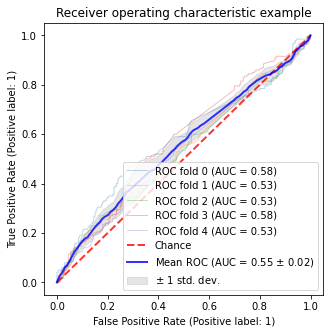

In [236]:
acc03, prec03, rec03, auc03 = svm_result1(classifier, X03, y03)

#### Temprature = 0.5

In [204]:
X05 = news05['clean_news'].reset_index(drop=True)
y05 = news05['class'].reset_index(drop=True)

Avg Accuracy: 0.544
Avg Precision 0.543
Avg Recall 0.559
Avg Auc: 0.556


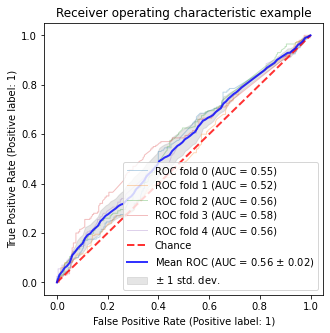

In [205]:
acc05, prec05, rec05, auc05 = svm_result1(classifier, X05, y05)

#### Temperature = 0.7

In [206]:
X07 = news07['clean_news'].reset_index(drop=True)
y07 = news07['class'].reset_index(drop=True)

Avg Accuracy: 0.526
Avg Precision 0.528
Avg Recall 0.482
Avg Auc: 0.541


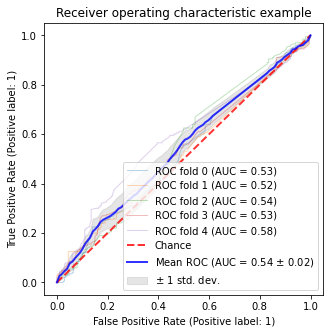

In [207]:
acc07, prec07, rec07, auc07 = svm_result1(classifier, X07, y07)

#### Temperature = 1.0

In [208]:
X10 = news10['clean_news'].reset_index(drop=True)
y10 = news10['class'].reset_index(drop=True)

Avg Accuracy: 0.56
Avg Precision 0.562
Avg Recall 0.541
Avg Auc: 0.587


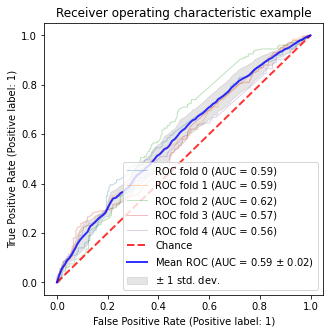

In [209]:
acc10, prec10, rec10, auc10 = svm_result1(classifier, X10, y10)

#### SVM Conclusion

In [237]:
temp_list = [0.3, 0.5, 0.7, 1.0]
acc_list = [acc03, acc05, acc07, acc10]
prec_list = [prec03, prec05, prec07, prec10]
rec_list = [rec03, rec05, rec07, rec10]
#auc_list = [auc03, auc05, auc07, auc10]

In [238]:
print(prec_list, rec_list)

[0.54, 0.543, 0.528, 0.562] [0.53, 0.559, 0.482, 0.541]


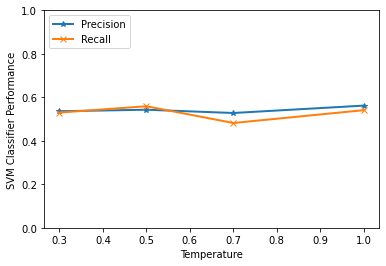

In [241]:
#plt.plot(temp_list, acc_list, label = 'Accuracy', marker = 'o', markersize=8, lw=2)
plt.plot(temp_list, prec_lsit, label = 'Precision', marker = '*',lw=2)
plt.plot(temp_list, rec_list, label = 'Recall', marker = 'x',lw=2)
#plt.plot(temp_list, acc_list, label = 'AUC Score', marker = 'v',lw=2)
plt.xlabel('Temperature')
plt.ylabel('SVM Classifier Performance')
plt.yticks([0, 0.2,0.4, 0.6, 0.8, 1.0])
plt.legend(loc='upper left')
plt.show()